In [1]:
from data_sim_module import *

# plotting
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size" : 15, 
                     "figure.dpi" : 100, 
                     "legend.fontsize" : 13, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True, 
                     "figure.figsize":(6, 5)})

import numpy as np
from sklearn.metrics.pairwise import cosine_distances

In [2]:
def weighted_hamming(X):
    
    # compute number of categories per feature
    pi_k = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        pi_k[i] = len(set(X[:,i]))
    pi_k = 1/pi_k

    H = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            hamming = np.sum(np.array(X[i] != X[j]) * pi_k)
            H[i][j] = hamming
            H[j][i] = hamming
            
    return H


# code is adapted from:
# https://github.com/arashbehboodi/DiffusionMap


def diffusionmap(distance_mat, n, eps, t, n_eigen, alpha=1/2):
    """
    distance_mat: distance matrix
    t: t indicates the number of iterations.
    n_eigen: indicates the target dimension for dimensionality reduction
    eps: is the parameter of Guassian kernel that is used.
    """
    # Kernel function for weight matrx: Gaussian Kernel
    # Constructing the weight matrix
    W = np.exp(-distance_mat/eps)
    
    # Degree matrix
    Deg = W@np.ones((n, 1))
    D = np.diag(Deg.reshape(n,))
    
    # Transition matrix
    M = np.linalg.inv(D)@W
    
    # Constructing the matrix S - obtaining diffusion vectors
    S = D**(alpha)@M@np.linalg.inv(D)**(alpha)
    
    # Spectral decomposition
    eigvalCov, eigvecCov = np.linalg.eig(S)
    idx = eigvalCov.argsort()[::-1]
    eigvalCov = eigvalCov[idx]
    eigvecCov = eigvecCov[:, idx]
    
    # Diffusion Map
    phiD = np.linalg.inv(D)**(alpha)@eigvecCov
    lambdaD = eigvalCov**t
    
    # Final Matrix with columns as the vectors
    DiffM = np.diag(lambdaD)@phiD.T
    Difftruncated = DiffM[1:n_eigen+1, :]
    return Difftruncated.T

In [3]:
NQ = 7
NA = 3

num_groups = 20
results = {}

kappa = np.linspace(1, (NA**NQ)-1, 30, dtype=int)
m_vals = np.linspace(1, 10, 10)

for k in kappa:
    for m in m_vals:
    
        key = (k,m)
        results[key] = {}

        # PDFs
        probs = get_curve_samples(number_q=NQ, number_a=NA, samples=num_groups, m=m, sin_angle=k-1)

        # avg. MI
        MI = multi_partite_distance(probs, NQ, NA)
        results[key]["MI"] = np.mean(MI)

        # theoretical embedding
        true_mds = get_true_mds(probs)
        results[key]["theoretical_embedding"] = true_mds

        # sample questionnaire
        df = get_questionnaires(probs, count_answers=50, Nq=NQ, Na=NA)
        results[key]["df"] = df            

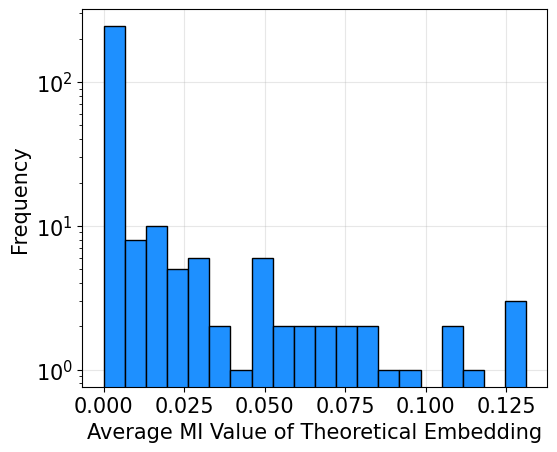

In [259]:
plt.hist([results[k]["MI"] for k in results], bins=20, color="dodgerblue", edgecolor="k")
plt.yscale("log")
plt.xlabel("Average MI Value of Theoretical Embedding")
plt.ylabel("Frequency")
plt.show()

# FINE correlations

In [4]:
FINE_corrs = {}
for k in results:
    true_mds = results[k]["theoretical_embedding"]
    df = results[k]["df"]
    _, mds_joint = compute_mds(df, dim=2, compute_joint=True)
    mds_joint = align_pca_mds(true_mds, mds_joint)
    fi_corr = corr_between_coords(true_mds, mds_joint)
    FINE_corrs[k] = fi_corr

# t-SNE correlations

In [5]:
TSNE_corrs = {}

for key in results:
    
    true_mds = results[key]["theoretical_embedding"]
    df = results[key]["df"]
    
    # one hot encode data
    data = OneHotEncoder(sparse=False, drop="if_binary").\
                fit_transform(df[["A_2", "B_3", "C_4", "D_5", "E_6", "F_7", "G_8"]])
    
    # compute weighted hamming distance
    X = weighted_hamming(data)
    
    # run t-SNE
    tsne = TSNE(n_components=2, perplexity=2, learning_rate=50, metric="precomputed",
                square_distances=True).fit_transform(X)
    tsne_coords = np.zeros(shape=(20, 2))
    
    # get barycenters
    for k, s in enumerate(df["name_1"].unique()):
        ind = df[df.name_1 == s].index
        tsne_coords[k,:] = np.mean(tsne[ind], axis=0)
    
    # align coordinates with theoretical embedding and compute correlation
    tsne_coords = align_pca_mds(true_mds, tsne_coords)
    TSNE_corrs[key] = corr_between_coords(true_mds, tsne_coords)

# DM correlations

In [6]:
DM_corrs = {}

for key in results:
    
    true_mds = results[key]["theoretical_embedding"]
    df = results[key]["df"]
    
    # one hot encode data
    data = OneHotEncoder(sparse=False, drop="if_binary").\
                fit_transform(df[["A_2", "B_3", "C_4", "D_5", "E_6", "F_7", "G_8"]])
    
    # compute cosine distance
    X = cosine_distances(data)

    # run DM
    dm = np.real(diffusionmap(X, len(X), eps=0.5, t=0.5, n_eigen=2))
    dm_coords = np.zeros(shape=(20, 2))
    
    # get barycenters
    for k, s in enumerate(df["name_1"].unique()):
        ind = df[df.name_1 == s].index
        dm_coords[k,:] = np.mean(dm[ind], axis=0)
    
    # align coordinates with theoretical embedding and compute correlation
    dm_coords = align_pca_mds(true_mds, dm_coords)
    corr = corr_between_coords(true_mds, dm_coords)
    DM_corrs[key] = corr    

# Delta plots

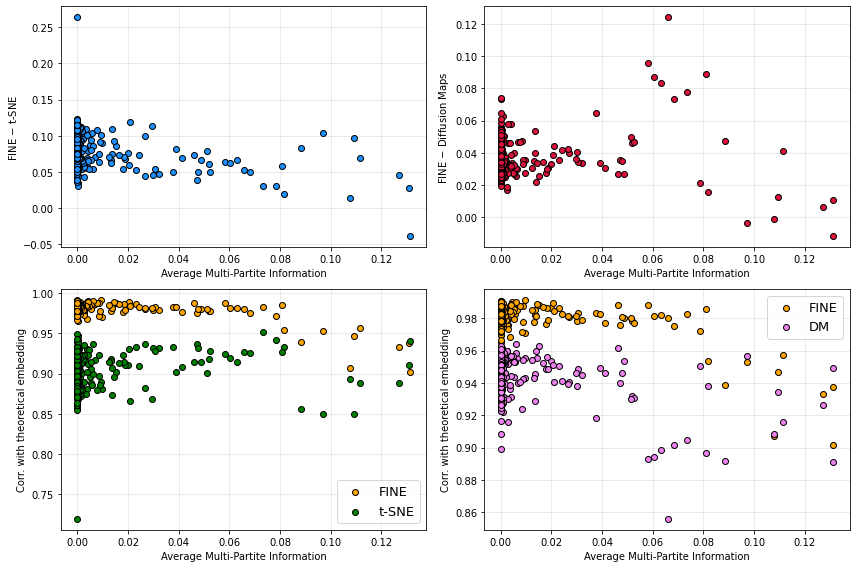

In [7]:
mi_values = [results[k]["MI"] for k in results]

delta_tsne = [FINE_corrs[k] - TSNE_corrs[k] for k in results]
delta_dm   = [FINE_corrs[k] - DM_corrs[k] for k in results]

colors=["dodgerblue", "crimson"]

algs = ["t-SNE", "Diffusion Maps"]

# using the variable axs for multiple Axes
fig, axs = plt.subplots(2, 2, figsize=(12,8))

for i, delta in enumerate([delta_tsne, delta_dm]):
    axs[0][i].scatter(mi_values, delta, color=colors[i], edgecolor="k")
    axs[0][i].set_xlabel("Average Multi-Partite Information")
    axs[0][i].set_ylabel(r"FINE $-$" +  f" {algs[i]}")

    
    
axs[1][0].scatter(mi_values, [FINE_corrs[k] for k in results], 
            color="orange", edgecolor="k", label="FINE")

axs[1][0].scatter(mi_values, [TSNE_corrs[k] for k in results], 
            color="green", edgecolor="k", label="t-SNE")
axs[1][0].set_xlabel("Average Multi-Partite Information")
axs[1][0].set_ylabel("Corr. with theoretical embedding")
axs[1][0].legend()


axs[1][1].scatter(mi_values, [FINE_corrs[k] for k in results], 
            color="orange", edgecolor="k", label="FINE")

axs[1][1].scatter(mi_values, [DM_corrs[k] for k in results], 
            color="violet", edgecolor="k", label="DM")
axs[1][1].set_xlabel("Average Multi-Partite Information")
axs[1][1].set_ylabel("Corr. with theoretical embedding")
axs[1][1].legend()


fig.tight_layout()
plt.savefig("delta_plot.pdf", bbox_inches="tight")
plt.show()